In [1]:
# Importing some important libraries
import glob
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
from ipywidgets import *
import pickle as pk
import sncosmo
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1d
import math
from tabulate import tabulate
#from PTMCMCSampler import PTMCMCSampler
from scipy.integrate import quad
import astropy.units as u
import astropy.constants as const
from scipy.optimize import minimize
import emcee

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
_SCALE_FACTOR = 1e-12

# phase (x) and wavelength (y)
gridx = np.linspace(-8, 48, 48+8+1, dtype=int) # in days
gridy = np.linspace(3500, 8300, int((8300-3500)/10+1), dtype=int) # in Angstroms

# phase (x) and wavelength (y)
gridx_salt2 = np.linspace(-20, 50, 50+20+1, dtype=int) # in days
gridy_salt2 = np.linspace(2000, 9200, 721, dtype=int) # in Angstroms


# Meshhgrid to show a matplotlib graph 
B1, B2 = np.meshgrid(gridx, gridy, indexing='xy')
# (x, y) grid data
xv = []
yv = []
for i in range(0, len(gridy)):
    for j in range(0, len(gridx)):
        xv.append(gridx[j])
        yv.append(gridy[i])
        
# Our pickles paths
pca_path = './PCA_FA_components/PCA/'
fa_path = './PCA_FA_components/FA/'
# Our SEDs path
surfaces_path = './SEDs_matern/'

%matplotlib inline

In [2]:
pickle_pca_path = glob.glob(pca_path+'*.pkl')

In [3]:
np.random.random(42)
if len(pickle_pca_path)>0:
    print('Loading our pca and fa models...')
    pca = pk.load(open(pca_path+'pca.pkl','rb'))
    fa = pk.load(open(fa_path+'fa.pkl','rb'))
    N_comp = 3
else:
    print('Training our model, please wait...')
    # Here, we use glob to know all .dat files names in the befores path
    file_names = glob.glob(surfaces_path+'*.dat')

    # Data & Data erro in a shape of N X x-Length X y-Length
    data = []
    data_err = []
    for i in range(0, len(file_names)):
        surface = pd.read_csv(file_names[i])
        data.append(np.array(surface['flux']))
        data_err.append(np.array(surface['fluxerr']))

    # Training our model using Principal Component Analysis and Factor Analysis
    # Number of components 
    N_comp = 3
    # Defining a PCA instance and fitting
    pca = PCA(N_comp)
    pca.fit(data)
    # Defining a FA instance and fitting
    fa = FactorAnalysis(N_comp)
    fa.fit(data+data_err)
    
    pk.dump(pca, open(pca_path+'pca.pkl','wb'))
    pk.dump(fa, open(fa_path+'fa.pkl','wb'))
    print('Done!')

Loading our pca and fa models...


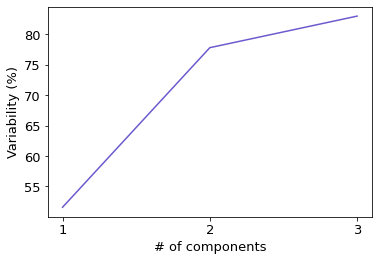

In [4]:
plt.rcParams.update({"font.size": 13})
plt.plot(np.linspace(1, N_comp, N_comp, dtype=int), np.cumsum(pca.explained_variance_ratio_)*100, color="slateblue")
plt.xlabel('# of components')
plt.ylabel('Variability (%)')
plt.xticks(np.linspace(1, N_comp, N_comp, dtype=int))
#plt.axvline(x=3, color='k', linestyle='--', label='EXP(3)')
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)
#plt.legend();

In [5]:
print("Explained variance in 3 components: ", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])

Explained variance in 3 components:  0.829614884207448


/tmp/ipykernel_678/583178012.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


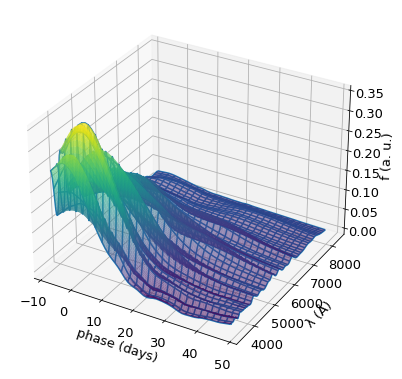

In [6]:
# Mean surface
Z = interp.griddata((xv, yv),pca.mean_,(B1,B2),method='cubic')
fig = plt.figure(figsize=(7, 5))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
ax.set_xlabel("phase (days)")
ax.set_ylabel("λ (Å)")
ax.set_zlabel("f (a. u.)")

plt.show()

/tmp/ipykernel_678/2111624935.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


interactive(children=(Dropdown(description='Component:', options=(0, 1, 3), value=0), Output()), _dom_classes=…

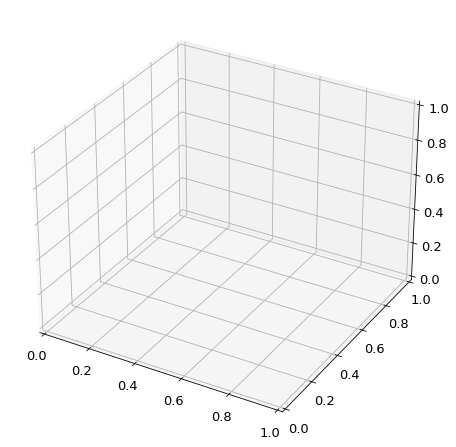

In [7]:
option_list = np.linspace(0, len(fa.components_), len(fa.components_), dtype=int)

#matplotlib notebook

fig = plt.figure(figsize=(10, 6))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()
    
    Z = interp.griddata((xv,yv), pca.components_[i], (B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    ax.set_xlabel("phase (days)")
    ax.set_ylabel("λ (Å)")
    ax.set_zlabel("f (a. u.)")
    plt.show()
    
i = widgets.Dropdown(options=option_list, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [8]:
M0_salt2 = pd.read_csv("./SALT2_templates/salt2_template_0.dat", names=["time", "wave", "flux"], sep="\s+")
M1_salt2 = pd.read_csv("./SALT2_templates/salt2_template_1.dat", names=["time", "wave", "flux"], sep="\s+")
c = pd.read_csv("./SALT2_templates/salt2_colour_law_guy2010.dat", header = None, sep = "\s+") # color term
c.columns = ["wave", "ext"]
c.head()

wave      ext
0  3000  4.44356
1  3010  4.35652
2  3020  4.27089
3  3030  4.18667
4  3040  4.10384

In [9]:
M = []
for i in range(0, len(fa.components_)):
    M.append(fa.components_[i].reshape(len(gridy), len(gridx)).T)

In [10]:
HC_ERG_AA

1.9864458571489284e-08

In [11]:
# A new class for sncosmo
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9', 'c']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'c']
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, LC, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0*_SCALE_FACTOR)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1*_SCALE_FACTOR)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2*_SCALE_FACTOR)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3*_SCALE_FACTOR)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4*_SCALE_FACTOR)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5*_SCALE_FACTOR)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6*_SCALE_FACTOR)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7*_SCALE_FACTOR)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8*_SCALE_FACTOR)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9*_SCALE_FACTOR)
        self._model_ext =  Spline1d(LC['wave'], LC['ext'],  k=1)  

        self._parameters = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # initial guess
        
    def _flux(self, phase, wave):
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, c = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave) +  x4 * self._model_flux4(phase, wave)  +  x5 * self._model_flux5(phase, wave) +  x6 * self._model_flux6(phase, wave) +  x7 * self._model_flux7(phase, wave) +  x8 * self._model_flux8(phase, wave) +  x9 * self._model_flux9(phase, wave))* 10.** (-0.4 * self._model_ext(wave) * c)
   
    def _bandflux_rvar_single(self, band, phase):
        print('single')
        x0 = self._parameters[0]
        x1 = self._parameters[1]
        x2 = self._parameters[2]

        wave, dwave = band.minwave()+(band.maxwave() - band.minwave())/2, 10.
        trans = band(wave) # transmission
        
        m0 = self._model_flux0(phase, wave)
        m1 = self._model_flux1(phase, wave)
        m2 = self._model_flux2(phase, wave)
        tmp = trans * wave
            
        m0int = np.sum(m0 * tmp, axis=1) * dwave/HC_ERG_AA
        m1int = np.sum(m1 * tmp, axis=1) * dwave/HC_ERG_AA
        m2int = np.sum(m2 * tmp, axis=1) * dwave/HC_ERG_AA
        return ((m0int+x1*m1int+x2*m2int)*0.008083732930093502)**2 + (m1int*x0*0.2617690714197349)**2 + (m2int*x0*0.34451843421019135)**2

    # teste
    def bandflux_rcov(self, band, phase):
        print('rcov')
        diagonal = np.zeros(phase.shape, dtype=np.float64)
        for b in set(band):
            mask = band == b
            diagonal[mask] = self._bandflux_rvar_single(b, phase[mask])
            
        return np.diagflat(diagonal)


In [12]:
lc_fit_table_exp = glob.glob('./cosmo_results/*exp3.dat')
#lc_fit_table_exp = []

In [13]:
lc_fit_table_exp

['./cosmo_results/matern_fit_exp3.dat']

In [14]:
table_exp3 = []

In [15]:
outliers = [19, 106, 107]

In [16]:
if len(lc_fit_table_exp) > 0:
    print('Loading our light curve parameters...')
    exp3_fit = pd.read_csv('./cosmo_results/matern_fit_exp3.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv','cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])
else:
    print('Applying fits to our SNe')
    exp_lc = EXP_LC(gridx, gridy, M[0], M[1], M[2], M[2], M[2], M[2], M[2], M[2], M[2], M[2], c) # change to M[2] to other orders SEDs
    files = glob.glob('./JLA/*.list')
    print("JLA files in path: ", len(files))

    for i in range(0, len(files)):
        print(i)
        if i not in outliers:
            data = sncosmo.read_lc(files[i], format='salt2')
            if data["Filter"][0][:-3] == "MEGACAMPSF":
                r = math.sqrt(data.meta['X_FOCAL_PLANE']**2 + data.meta['Y_FOCAL_PLANE']**2)
                megacg = sncosmo.get_bandpass('megacampsf::g', r)
                megacr = sncosmo.get_bandpass('megacampsf::r', r)
                megaci = sncosmo.get_bandpass('megacampsf::i', r)
                megacz = sncosmo.get_bandpass('megacampsf::z', r)

                sncosmo.register(megacg, 'MEGACAMPSF::g', force = True)
                sncosmo.register(megacr, 'MEGACAMPSF::r', force = True)
                sncosmo.register(megaci, 'MEGACAMPSF::i', force = True)
                sncosmo.register(megacz, 'MEGACAMPSF::z', force = True)

            snname = data.meta['SN']
            print(snname)
            exp3 = sncosmo.Model(source=exp_lc,
                                 effects=[sncosmo.F99Dust()],
                                 effect_names=['mw'],
                                 effect_frames=['obs'])

            exp3.set(mwebv=data.meta['MWEBV'],
                    z = data.meta['Z_HELIO'],
                    x3 = 0,
                    x4 = 0,
                    x5 = 0,
                    x6 = 0,
                    x7 = 0,
                    x8 = 0,
                    x9 = 0,
                    c = 0)

            result_exp3, m_exp3 = sncosmo.fit_lc(data, exp3, ['t0', 'x0', 'x1', 'x2'], modelcov=True, phase_range=(-8, 48.), wave_range=(3500., 8300.), verbose=False)

            if result_exp3.success == True:
                if result_exp3.ndof > 2:
                    print(result_exp3.chisq/result_exp3.ndof)
                    table_exp3.append((snname, result_exp3.parameters[0], result_exp3.parameters[1], result_exp3.errors['t0'], result_exp3.parameters[2], result_exp3.errors['x0'], result_exp3.parameters[3], result_exp3.errors['x1'], result_exp3.parameters[4], result_exp3.errors['x2'], data.meta['MWEBV'], result_exp3.covariance[1][2], result_exp3.covariance[1][3], result_exp3.covariance[2][3], result_exp3.chisq/result_exp3.ndof, "exp3"))

    save_path = './cosmo_results/'
    completeName = os.path.join(save_path,'matern_fit_exp3.dat')
    f = open(completeName, 'w')        
    f.write(tabulate(table_exp3, tablefmt='plain'))
    f.close()
    
    print('Loading our light curve parameters...')
    exp3_fit = pd.read_csv('./cosmo_results/matern_fit_exp3.dat',
                           sep='\s+',
                           names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv', 'cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])


Loading our light curve parameters...


In [17]:
exp3_fit_nocov = pd.read_csv('./cosmo_results/matern_fit_exp3_nocov.dat',
                        sep='\s+',
                        names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv', 'cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])


In [18]:
exp3_fit_nocov.head()

name  redshift       t0        t0_err        x0        x0_err        x1  \
0  03D1au    0.5043  52910.6  2.470730e-01  0.000030  6.132440e-07  0.254633   
1  03D1aw    0.5820  52899.3  6.017220e-09  0.000013  2.566260e-06 -1.097120   
2  03D1ax    0.4960  52916.5  3.381900e-05  0.000024  5.134450e-07 -0.911936   
3  03D1bp    0.3470  52919.3  6.073800e-05  0.000047  4.344940e-07  0.205477   
4  03D1co    0.6790  52950.9  3.881430e-04  0.000010  8.350480e-07  0.541752   

     x1_err        x2    x2_err   mwebv      cov_x0x1      cov_x0x2  cov_x1x2  \
0  0.087649 -0.496415  0.116260  0.0296  5.039030e-08  6.830020e-08  0.009411   
1  1.047310 -2.507690  1.601010  0.0252  2.676560e-06  4.095260e-06  1.667330   
2  0.117513 -0.486852  0.134829  0.0264  5.082640e-08  6.352980e-08  0.010819   
3  0.050134  0.400482  0.064642  0.0236  1.561450e-08  2.265380e-08  0.001901   
4  0.341222 -0.390626  0.484815  0.0299  2.674550e-07  3.902590e-07  0.159379   

   chiquad/dof model  
0      1.45727  exp3  
1      8.93582  exp3  
2     11.36370  exp3  
3     44.11520  exp3  
4      7.01169  exp3

In [19]:
len(exp3_fit_nocov['chiquad/dof'][exp3_fit_nocov['chiquad/dof']<5.])

519

In [20]:
len(exp3_fit['chiquad/dof'][exp3_fit['chiquad/dof']<5.])

518

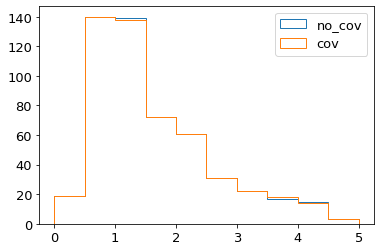

In [21]:
plt.hist(exp3_fit_nocov['chiquad/dof'], label='no_cov', density=False, range=(0, 5), histtype='step')
plt.hist(exp3_fit['chiquad/dof'], label='cov', density=False, range=(0, 5),  histtype='step')
plt.legend()

### exp cuts

In [22]:
exp3_fit = exp3_fit[exp3_fit['chiquad/dof']<5.]

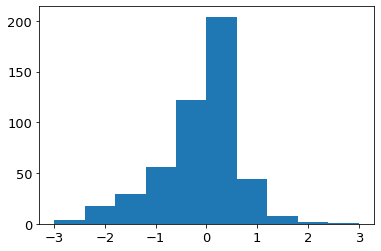

In [23]:
plt.hist(exp3_fit['x1'], range=(-3, 3));

In [24]:
exp3_fit = exp3_fit[np.abs(exp3_fit['x1'])<3.]
len(exp3_fit)

488

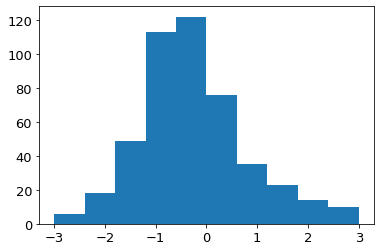

In [25]:
plt.hist(exp3_fit['x2'], range=(-3, 3));

In [26]:
exp3_fit = exp3_fit[np.abs(exp3_fit['x2'])<3.]
len(exp3_fit)

466

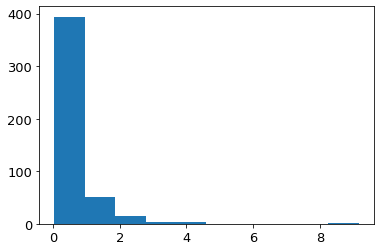

In [27]:
plt.hist(exp3_fit['x2_err']);

In [28]:
np.min(exp3_fit['x2_err'])

0.0398172

In [29]:
exp3_fit.reset_index(drop=True, inplace=True)

In [30]:
exp3_fit["mb"]= -2.5*np.log10(exp3_fit["x0"])+10 #referencia
exp3_fit["mb_err"] = 1.08574*(exp3_fit["x0_err"])/exp3_fit["x0"]

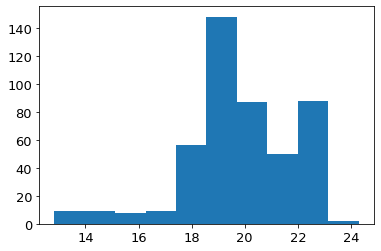

In [31]:
plt.hist(exp3_fit['mb']);

In [32]:
min(exp3_fit['mb'])

12.82730517804439

### salt2 cuts

In [33]:
print('Loading our light curve parameters...')
salt2_fit = pd.read_csv('./cosmo_results/fit_salt2.dat',
                       sep='\s+',
                       names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'c', 'c_err', 'mwebv', 'cov_x0x1', 'cov_x0c', 'cov_x1c', 'chiquad/dof', 'model'])


Loading our light curve parameters...


In [34]:
salt2_fit.drop(salt2_fit.index[salt2_fit["chiquad/dof"]>3], axis=0, inplace=True)
salt2_fit.drop(salt2_fit.index[abs(salt2_fit["x1"])>3], axis=0, inplace=True)
salt2_fit.drop(salt2_fit.index[abs(salt2_fit["c"])>2], axis=0, inplace=True)

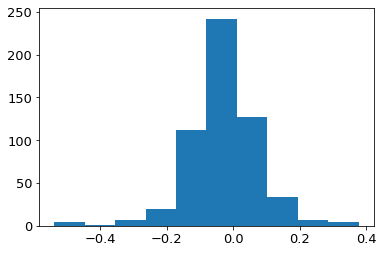

In [35]:
plt.hist(salt2_fit['c']);

In [36]:
salt2_fit["mb"]= -2.5*np.log10(salt2_fit["x0"])+10 #referencia
salt2_fit["mb_err"] = 1.08574*(salt2_fit["x0_err"])/salt2_fit["x0"]

In [37]:
salt2_fit.reset_index(drop=True, inplace=True)

In [38]:
salt2_fit

name  redshift       t0    t0_err            x0        x0_err  \
0       03D1au  0.504300  52909.7  0.184387  1.135650e-05  8.286350e-08   
1       03D1ax  0.496000  52916.1  0.101686  1.144130e-05  9.210410e-08   
2       03D1co  0.679000  52954.4  0.451643  4.168300e-06  1.590080e-07   
3       03D1ew  0.868000  52991.3  2.827410  3.271700e-06  2.214530e-07   
4       03D1fq  0.800000  53000.0  0.758061  2.889750e-06  1.087450e-07   
..         ...       ...      ...       ...           ...           ...   
553   sn2007ae  0.064388  54153.5  0.438483  1.417640e-03  2.613910e-05   
554   sn2007bc  0.020771  54200.5  0.104422  7.666070e-03  6.610020e-05   
555   sn2007bd  0.031018  54206.2  0.056564  4.285290e-03  1.689450e-05   
556    sn2007f  0.023590  54124.0  0.032918  7.870480e-03  3.157010e-05   
557  Torngasek  1.265000  52693.6  2.157650  8.978490e-07  2.857350e-08   

           x1    x1_err         c     c_err   mwebv      cov_x0x1  \
0    1.292900  0.134236 -0.020352  0.012490  0.0296 -6.719740e-09   
1   -0.840369  0.104929 -0.030900  0.013322  0.0264 -5.879210e-09   
2    0.769722  0.522152 -0.033253  0.042096  0.0299 -7.236470e-08   
3    0.568715  0.898579 -0.176071  0.232806  0.0272  8.489880e-08   
4   -1.361520  0.475088 -0.226075  0.281432  0.0261 -2.800260e-08   
..        ...       ...       ...       ...     ...           ...   
553  1.282060  0.176220 -0.040879  0.009799  0.0450  1.424060e-06   
554 -1.165970  0.046793  0.023142  0.006560  0.0220 -6.864340e-07   
555 -1.233270  0.041920 -0.066050  0.003382  0.0340 -1.765370e-07   
556  0.628372  0.026171 -0.034816  0.002843  0.0170 -4.331480e-07   
557  0.287913  0.612054  0.055215  0.053070  0.0123  4.751660e-09   

          cov_x0c   cov_x1c  chiquad/dof  model         mb    mb_err  
0   -2.978810e-10 -0.000203      1.02367  salt2  22.361889  0.007922  
1   -4.059190e-10 -0.000103      2.01389  salt2  22.353812  0.008740  
2   -1.714290e-09  0.008467      1.37515  salt2  23.450103  0.041418  
3    4.138220e-08  0.020887      2.75364  salt2  23.713066  0.073491  
4    1.640750e-08  0.012081      1.20485  salt2  23.847849  0.040858  
..            ...       ...          ...    ...        ...       ...  
553 -1.643020e-07  0.000120      1.85156  salt2  17.121085  0.020019  
554 -3.105460e-07  0.000008      2.75907  salt2  15.288568  0.009362  
555 -4.349510e-08  0.000013      2.77554  salt2  15.920049  0.004280  
556 -7.419510e-08  0.000016      2.89571  salt2  15.259997  0.004355  
557  4.099840e-10  0.010309      1.52211  salt2  25.116992  0.034553  

[558 rows x 18 columns]

In [39]:
class make_cosmo:
    def __init__(self, data):
        """
        calculates a chi squared function depending on the model
        data: pd dataframe
        """
        self.data = data
        
    def integrando_dl(self, x, Om_m, Om_l):
        '''
        cmb redshift = x
        Omega matter density = Om_m
        Omega cosmologic constant density = Om_l

        :return = integrand
        '''
        return (1/(np.sqrt(Om_m*(1 + x)*(1 + x)*(1 + x) + Om_l + (1.0 - Om_m - Om_l)*(1 + x)*(1 + x))))
    
    #test function for luminosity distance
    def luminosity_d(self, Om_k, integral):
        '''
        Omega curvature density = Om_k
        Integral value = integral

        :return = luminosity distance/(1+redshift)
        '''
        if(Om_k > 0):
            result = (1/np.sqrt(Om_k))*np.sinh(np.sqrt(Om_k)*integral)
        if(Om_k == 0):
            result = integral
        if(Om_k < 0):
            result = (1/np.sqrt(-Om_k))*np.sin(np.sqrt(-Om_k)*integral)

        return result
    
    def lnpriorfn_exp3(self, par):
        if -22. < par[0] < -19. and 0. < par[1] < 1. and -1. < par [2] < 0. and  0.1 < par[3] < 1. and .1 < par[4] < 1. and  .0 < par[5] < 1.0:
            return 0.
        else:
            return -np.inf  
        
    def model(self, par):
        """
        chi squared function of exp3
        par: list/np array (free parameters)
        """
        [M, a, b, Om_m, Om_l, h] = par
        #curvature density  
        Om_k = 1.0 - float(Om_m) - float(Om_l)

        muth = np.zeros(len(self.data))
        #print(M, a, b, Om_m, Om_l)
        #to calculate luminosity distance with Om_m and Om_l as arguments
        for ii in range(0, len(self.data)):
            #integral value
            I = quad(self.integrando_dl, 0, self.data["redshift"][ii], args = (Om_m, Om_l))
            #luminosity distance
            dl = (1 + self.data["redshift"][ii])*self.luminosity_d(Om_k, I[0])
            #theoric distance module
            muth[ii] = 5*np.log10(dl) - 5*np.log10(h) + 42.3856062736
            
        muexp = self.data["mb"] - M - 2.5*np.log10(1 - self.data["x1"]*a - self.data["x2"]*b)  
        
        #cov_err = 2*1.08574*a*b*self.data["cov_x1x2"]/(1-a*self.data["x1"]-b*self.data["x2"])**2
        E_muexp_quad = self.data["mb_err"]*self.data["mb_err"] + ((1.08574*a/(1-a*self.data["x1"] - b*self.data["x2"]))*self.data["x1_err"])**2 + ((1.08574*b/(1-a*self.data["x1"] + b*self.data["x2"]))*self.data["x2_err"])**2
        
        chi_squared = np.sum(((muexp - muth)**2)/E_muexp_quad)
        log_part = np.sum(np.log(E_muexp_quad))
        chi_total = chi_squared + log_part + len(E_muexp_quad)*2*np.pi + len(self.data)*2*np.pi
        return -chi_total
    
    def log_probability_exp3(self, par):
        lp = self.lnpriorfn_exp3(par)
        if not np.isfinite(lp):
            return -np.inf
        else:
            return lp + self.model(par)
    
    def lnpriorfn_salt2(self, par):
        if -22. < par[0] < -19. and 0. < par[1] < 1. and 0. < par [2] < 5. and  0.1 < par[3] < 1. and .1 < par[4] < 1. and  .0 < par[5] < 1.0:
            return 0.
        else:
            return -np.inf 
    
    def model_salt2(self, par):
        """
        chi squared function of salt2
        par: list/np array (free parameters)
        """
        [M, a, b, Om_m, Om_l, h] = par
        
        #curvature density  
        Om_k = 1.0 - float(Om_m) - float(Om_l)

        muth = np.zeros(len(self.data))
        #print(M, a, b, Om_m, Om_l)
        #to calculate luminosity distance with Om_m and Om_l as arguments
        for ii in range(0, len(self.data)):

            #integral value

            I = quad(self.integrando_dl, 0, self.data["redshift"][ii], args = (Om_m, Om_l))

            #luminosity distance
            dl = (1 + self.data["redshift"][ii])*self.luminosity_d(Om_k, I[0])

            #theoric distance module
            
            muth[ii] = 5*np.log10(dl) - 5*np.log10(h) + 42.3856062736
        
        #experimental distance module array
        muexp = self.data["mb"] - M + a*self.data["x1"] - b*self.data["c"]   
        #cov_err = +(2*2.5/self.data["x0"]*np.log(10))*a*self.data["cov_x0x1"] - (2*2.5/self.data["x0"]*np.log(10))*b*self.data["cov_x0c"] - 2*a*b*self.data["cov_x1c"]

        E_muexp_quad = self.data["mb_err"]*self.data["mb_err"] + a*a*self.data["x1_err"]*self.data["x1_err"] + b*b*self.data["c_err"]*self.data["c_err"]

        chi_squared = np.sum(((muexp - muth)**2)/E_muexp_quad)

        log_part = np.sum(np.log(E_muexp_quad))
        chi_total = chi_squared + log_part + len(E_muexp_quad)*2*np.pi  + len(self.data)*2*np.pi
        return -chi_total    
    
    def log_probability_salt2(self, par):
        lp = self.lnpriorfn_salt2(par)
        if not np.isfinite(lp):
            return -np.inf
        else:
            return lp + self.model_salt2(par)

In [40]:
#cosmo = make_cosmo(exp3_fit)

In [41]:
#x0 = [-21.04, 0.62, 3, 0.37, 0.7, 0.7, 2.]
#res = minimize(cosmo.model, x0, method='Nelder-Mead', tol=1e-6)
#res.x

## MCMC Different models

* EXP(3)

In [42]:
ndim=6
nwalkers=30

In [43]:
cosmo = make_cosmo(exp3_fit)

In [44]:
x0 = np.array([-20.79397346, 0.63849491, -0.36565018, 0.37389424, 0.7163119 , 0.67142361])

In [45]:
sampler_exp3 = emcee.EnsembleSampler(nwalkers, ndim, cosmo.log_probability_exp3, threads=6)

In [46]:
p0 = x0+0.1*np.random.randn(nwalkers, ndim)

In [47]:
state_exp3 = sampler_exp3.run_mcmc(p0, 200)

sampler_exp3.reset()

/home/joao/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
sampler_exp3.run_mcmc(state_exp3, 500);

(array([2990., 3338., 3183., 2471., 1647.,  765.,  350.,  170.,   63.,
          23.]),
 array([0.10034714, 0.14057937, 0.18081161, 0.22104384, 0.26127607,
        0.3015083 , 0.34174054, 0.38197277, 0.422205  , 0.46243724,
        0.50266947]),
 [<matplotlib.patches.Polygon at 0x7ff498ec7d90>])

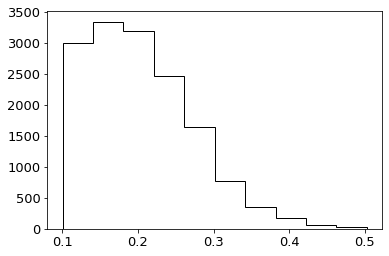

In [49]:
samples_exp3 = sampler_exp3.get_chain(flat=True)
plt.hist(samples_exp3[:, 3], color="k", histtype="step")

In [50]:
exp3_chain = pd.DataFrame(samples_exp3, columns=['M', 'a', 'b', 'om_m', 'om_l', 'h'])
exp3_chain.head()

M         a         b      om_m      om_l         h
0 -20.746441  0.484785 -0.370110  0.194015  0.574614  0.632134
1 -21.229780  0.497216 -0.370606  0.343156  0.726504  0.506382
2 -20.806902  0.506352 -0.368119  0.163682  0.505509  0.614077
3 -21.280961  0.492989 -0.363309  0.288159  0.680271  0.497179
4 -20.695401  0.478050 -0.362437  0.246328  0.579097  0.648520

(array([ 246., 1370., 3482., 3884., 3057., 1616.,  776.,  318.,  192.,
          59.]),
 array([0.38528246, 0.44405797, 0.50283348, 0.56160899, 0.62038449,
        0.67916   , 0.73793551, 0.79671101, 0.85548652, 0.91426203,
        0.97303753]),
 <BarContainer object of 10 artists>)

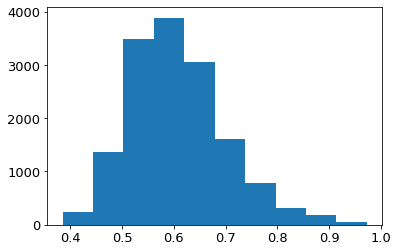

In [51]:
plt.hist(exp3_chain['om_l'])

In [52]:
exp3_chain.to_csv('./chains/chains_exp3/exp3_chain.csv')

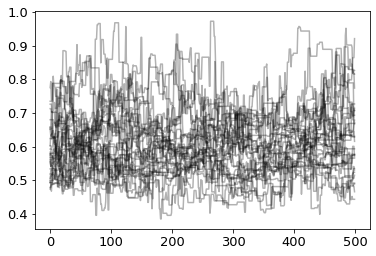

In [53]:
plt.plot(sampler_exp3.chain[:,:,4].T, '-', color='k', alpha=0.3);

* mcmc salt2

In [54]:
cosmo = make_cosmo(salt2_fit)

In [55]:
x0 = np.array([-20.91599244,   0.65133993,   3.01318986,   0.37133276, 0.70184364,   0.69873388])

In [56]:
sampler_salt2 = emcee.EnsembleSampler(nwalkers, ndim, cosmo.log_probability_salt2, threads=6)

In [57]:
p0 = x0+0.2*np.random.randn(nwalkers, ndim)

In [58]:
state_salt2 = sampler_salt2.run_mcmc(p0, 200)
sampler_salt2.reset()

/home/joao/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [59]:
sampler_salt2.run_mcmc(state_salt2, 500);

In [60]:
tau = sampler_salt2.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [55.97128821 43.37305689 43.28759096 35.36864334 34.88431171 55.85550117]

In [61]:
flat_samples = sampler_salt2.get_chain(discard=100, thin=10, flat=True)
print(flat_samples.shape)

(1200, 6)


(array([2702., 2284., 1652., 1585., 2202., 2428., 1274.,  534.,  141.,
         198.]),
 array([0.24572577, 0.25805002, 0.27037426, 0.2826985 , 0.29502275,
        0.30734699, 0.31967124, 0.33199548, 0.34431973, 0.35664397,
        0.36896822]),
 [<matplotlib.patches.Polygon at 0x7ff498f332b0>])

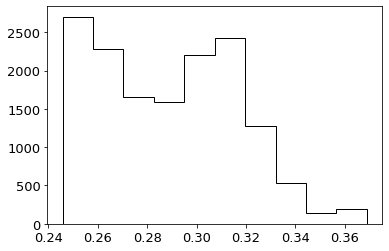

In [62]:
samples_salt2 = sampler_salt2.get_chain(flat=True)
plt.hist(samples_salt2[:, 5], color="k", histtype="step")

(array([ 24.,  53., 140., 312., 289., 204., 114.,  47.,  13.,   4.]),
 array([0.60900539, 0.63966078, 0.67031617, 0.70097156, 0.73162695,
        0.76228234, 0.79293773, 0.82359312, 0.85424851, 0.8849039 ,
        0.91555929]),
 <BarContainer object of 10 artists>)

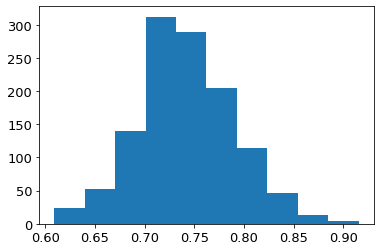

In [63]:
plt.hist(flat_samples.T[4])

In [64]:
salt2_chain = pd.DataFrame(samples_salt2, columns=['M', 'a', 'b', 'om_m', 'om_l', 'h'])
salt2_chain.head()

M         a         b      om_m      om_l         h
0 -21.906552  0.162293  3.178487  0.288795  0.729746  0.256731
1 -21.834657  0.168277  3.153819  0.305699  0.758610  0.265642
2 -21.860112  0.161839  3.134726  0.266151  0.705879  0.262543
3 -21.874914  0.162843  3.185866  0.326030  0.755942  0.260602
4 -21.424621  0.163488  3.087888  0.275334  0.680468  0.320304

In [65]:
salt2_chain.to_csv('./chains/chains_salt2/salt2_chain.csv')

In [66]:
salt2_chain

M         a         b      om_m      om_l         h
0     -21.906552  0.162293  3.178487  0.288795  0.729746  0.256731
1     -21.834657  0.168277  3.153819  0.305699  0.758610  0.265642
2     -21.860112  0.161839  3.134726  0.266151  0.705879  0.262543
3     -21.874914  0.162843  3.185866  0.326030  0.755942  0.260602
4     -21.424621  0.163488  3.087888  0.275334  0.680468  0.320304
...          ...       ...       ...       ...       ...       ...
14995 -21.264292  0.159520  3.148940  0.339582  0.799385  0.346031
14996 -21.868143  0.161379  3.133048  0.280443  0.729919  0.261566
14997 -21.660259  0.161291  3.122244  0.297141  0.720145  0.287482
14998 -21.676347  0.160319  3.133471  0.289771  0.755231  0.286093
14999 -21.311608  0.162396  3.114903  0.275752  0.729644  0.337951

[15000 rows x 6 columns]

* Chains analysis 

In [67]:
exp3_chain = pd.read_csv('./chains/chains_exp3/exp3_chain.csv')

In [68]:
salt2_chain = pd.read_csv('./chains/chains_salt2/salt2_chain.csv')

In [69]:
histogramsN = ['M', 'a', 'b', 'Om_m', 'Om_l', 'h']
latexN  = ['M', 'alpha', 'beta', '\Omega_m', '\Omega_\Lambda', 'h']

In [70]:
chain_1 = []
for i in range(0, len(exp3_chain)):
    if i > 0:
        chain_1.append([exp3_chain["M"][i], exp3_chain["a"][i], exp3_chain["b"][i], exp3_chain["om_m"][i], exp3_chain["om_l"][i], exp3_chain["h"][i]])

In [71]:
chain_2 = []
for i in range(0, len(salt2_chain)):
    if i > 0:
        chain_2.append([salt2_chain["M"][i], salt2_chain["a"][i], salt2_chain["b"][i], salt2_chain["om_m"][i], salt2_chain["om_l"][i], salt2_chain["h"][i]])

In [72]:
chain_1 = np.array(chain_1)
chain_2 = np.array(chain_2)

In [73]:
from getdist import plots, MCSamples

In [74]:
samples_1 = MCSamples(samples=chain_1, names = histogramsN, labels = latexN)
samples_2 = MCSamples(samples=chain_2, names = histogramsN, labels = latexN)

Removed no burn in
Removed no burn in


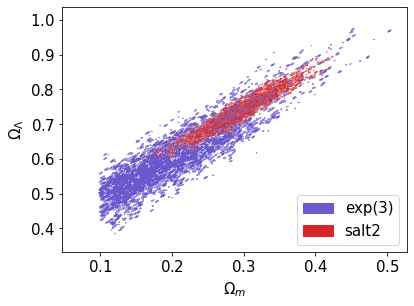

In [75]:
plt.rcParams.update({"font.size": 15})
g = plots.get_single_plotter(rc_sizes=True)

samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
g.settings.alpha_filled_add = 0.7

g.settings.num_plot_contours = 2
g.plot_2d([samples_1, samples_2], 'Om_m', 'Om_l',
          filled=True,
          line_args=[{'lw':1, 'color':'slateblue'}, {'lw':2, 'color':'C3'}],
          contour_colors=['C3','slateblue'])
g.add_legend(['exp(3)', 'salt2'], legend_loc='lower right')
plt.subplots_adjust(bottom=0.15)
#plt.xlim(0, 0.8)
#plt.ylim(0, 1.2)
#plt.savefig("/home/joao/Desktop/curvas_confianca.png", dpi = 200); #g.plot_2d(samplessalt2, 'Om_m', 'Om_l');

(array([0.27902779, 1.55393527, 3.94949095, 4.4054632 , 3.46743074,
        1.83296306, 0.88018523, 0.36069446, 0.21777779, 0.0669213 ]),
 array([0.38528246, 0.44405797, 0.50283348, 0.56160899, 0.62038449,
        0.67916   , 0.73793551, 0.79671101, 0.85548652, 0.91426203,
        0.97303753]),
 <BarContainer object of 10 artists>)

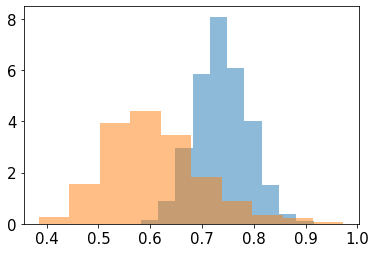

In [76]:
plt.hist(salt2_chain['om_l'], alpha=0.5, density=True)
plt.hist(exp3_chain['om_l'], alpha=0.5, density=True)

In [77]:
import corner

In [78]:
exp3 = np.array([samples_exp3.T[3], samples_exp3.T[4]])
salt2 = np.array([samples_salt2.T[3], samples_salt2.T[4]])

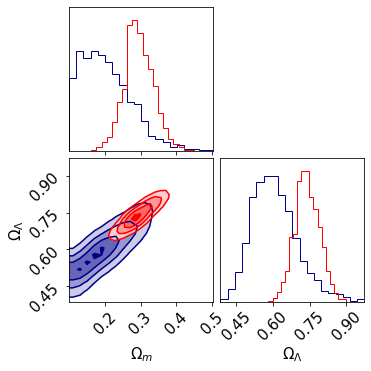

In [79]:
figure = corner.corner(exp3.T, color='darkblue', smooth=True, plot_density=False, plot_datapoints=False, show_titles=False, fill_contours=True, labels=['$\Omega_m$', '$\Omega_\Lambda$'])
corner.corner(salt2.T,fig=figure, color='r', smooth=True, plot_density=False, plot_datapoints=False, show_titles=False, fill_contours=True, labels=['$\Omega_m$', '$\Omega_\Lambda$']);

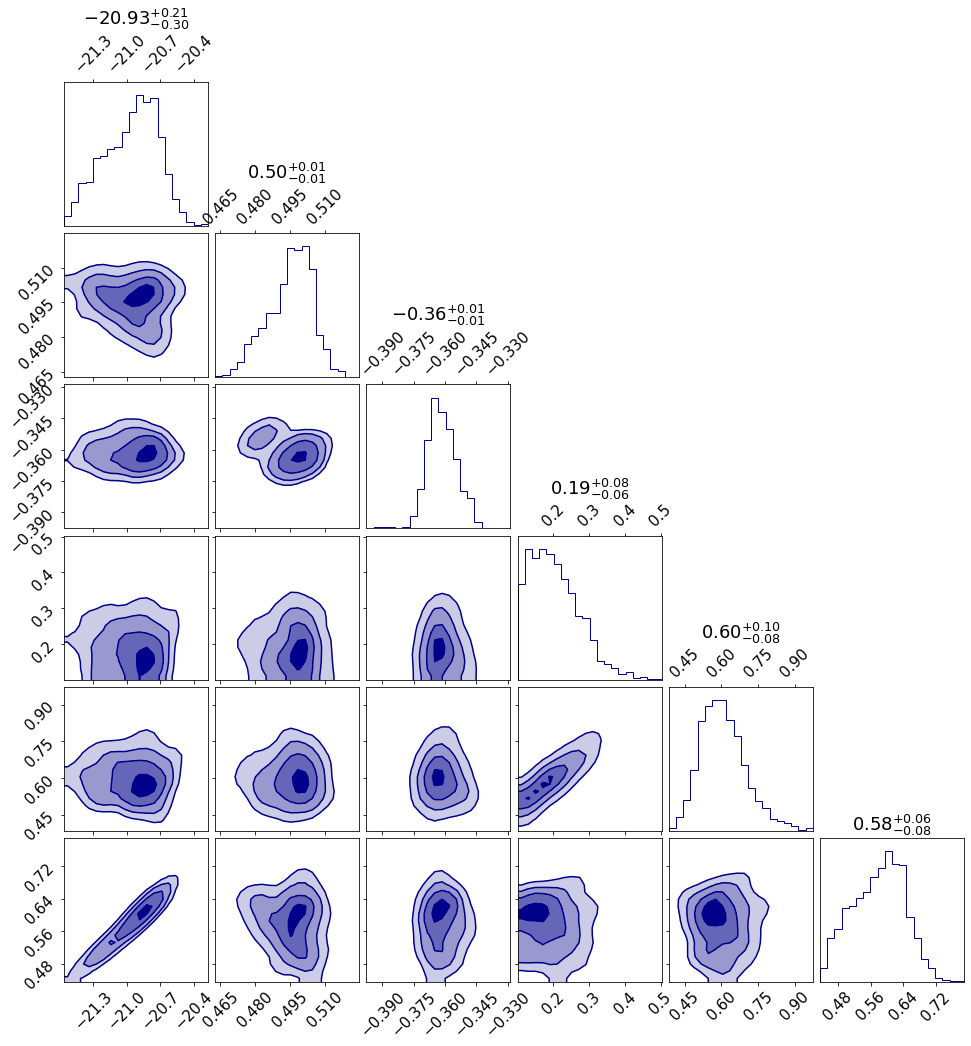

In [80]:
figure = corner.corner(samples_exp3, color='darkblue', smooth=True, plot_density=False, plot_datapoints=False, show_titles=True, fill_contours=True, top_ticks=True);

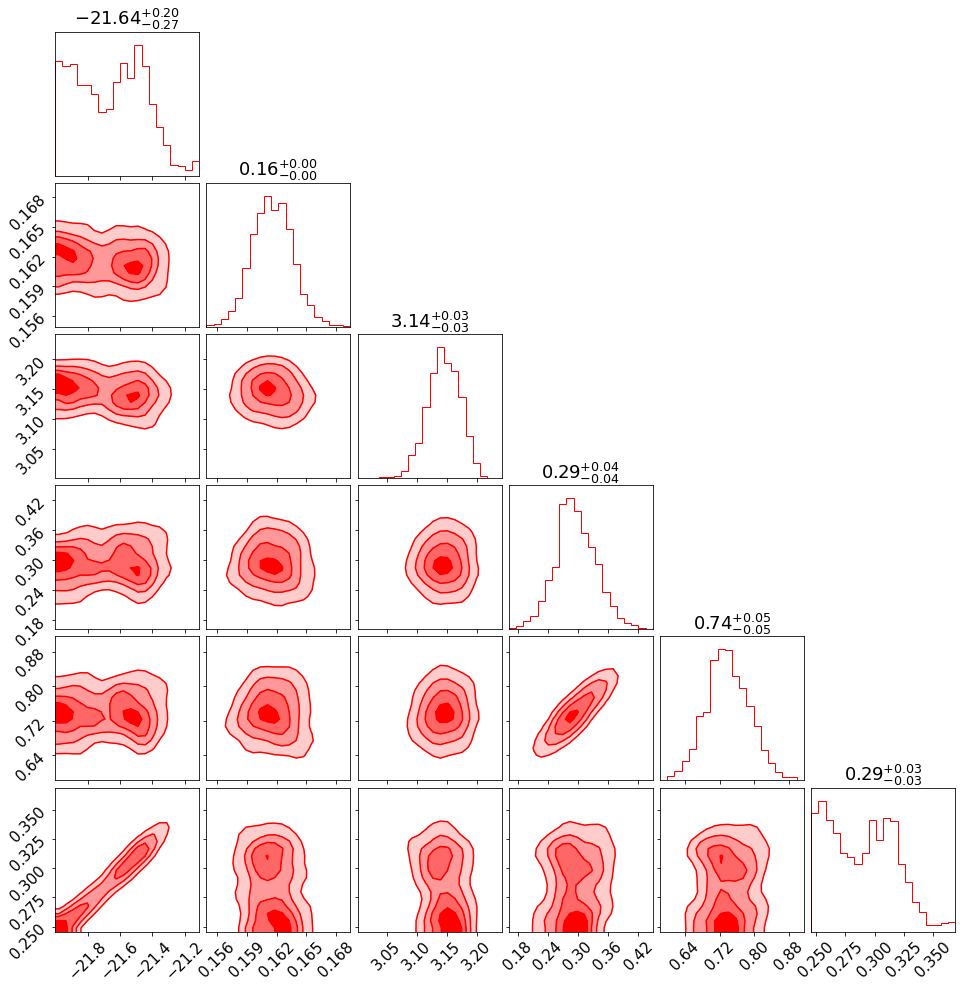

In [81]:
figure = corner.corner(samples_salt2, color='r', smooth=True, plot_density=False, plot_datapoints=False, show_titles=True, fill_contours=True)

In [ ]:
exp3_chain